# Binomial regression
- 合計n回の思考のうち、何度成功したかのカウント
- これらを「割合(proportion)」に落とし込むのは得策とは限らない
    * 情報を削ぎ落としすぎている

binomial regressionに対する適切な尤度は、二項分布で
$$ y_i \sim Binomial(n, p_i) $$
と表す。$y_i$: 成功回数  
binomial regressionで行いたいこと⇨ $ p_i(=\beta_0+\beta_1\cdot x_i) $の推定。よって以下の式が得られる。
$$ y_i \sim Binomial(n, \beta_0 + \beta_1 \cdot x_i) $$
こうすると、線形モデルにしたことで$p$が0~1に収まらなくなる。そこでリンク関数の出番。
$$ g(p_i) \sim \beta_0 + \beta_1 \cdot x_i $$
$g()$はリンク関数。これは、$(0, 1)$を$(-\infty, +\infty)$にマッピングすることと同等。これを可能にする１つの関数が、**ロジット関数**。

では逆に今やりたいことは、以下の式の通り。
$$ p_i = g^{-1}(\beta_0 + \beta_1 \cdot x_i) $$
$g^{-1}$は逆連結関数。ロジット関数の逆関数、つまり**ロジスティック・シグモイド関数**。したがって、尤度関数は以下のようになる。
$$ y_i \sim Binomial(n, \rm{InverseLogit} (\beta_0 + \beta_1 \cdot \it{x_i}))$$


**Next ToDo**: 
- ベイジアンBinomial regressionを$\beta$パラメータのpriorに対して行う
- 観測データ: $y_i, n, x_i$

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy.special import expit  # expit: ロジスティック関数の別名

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## データ生成

In [5]:
# true params
β0_true = 0.7
β1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
μ_true = β0_true + β1_true * x
# transformation (inverse logit function = expit)
p_true = expit(μ_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})

print(f"{len(data)=}")
data.head()

len(data)=30


,x,y
0,-10.000000,0
1,-8.965517,2
2,-7.931034,3
3,-6.896552,4
4,-5.862069,0


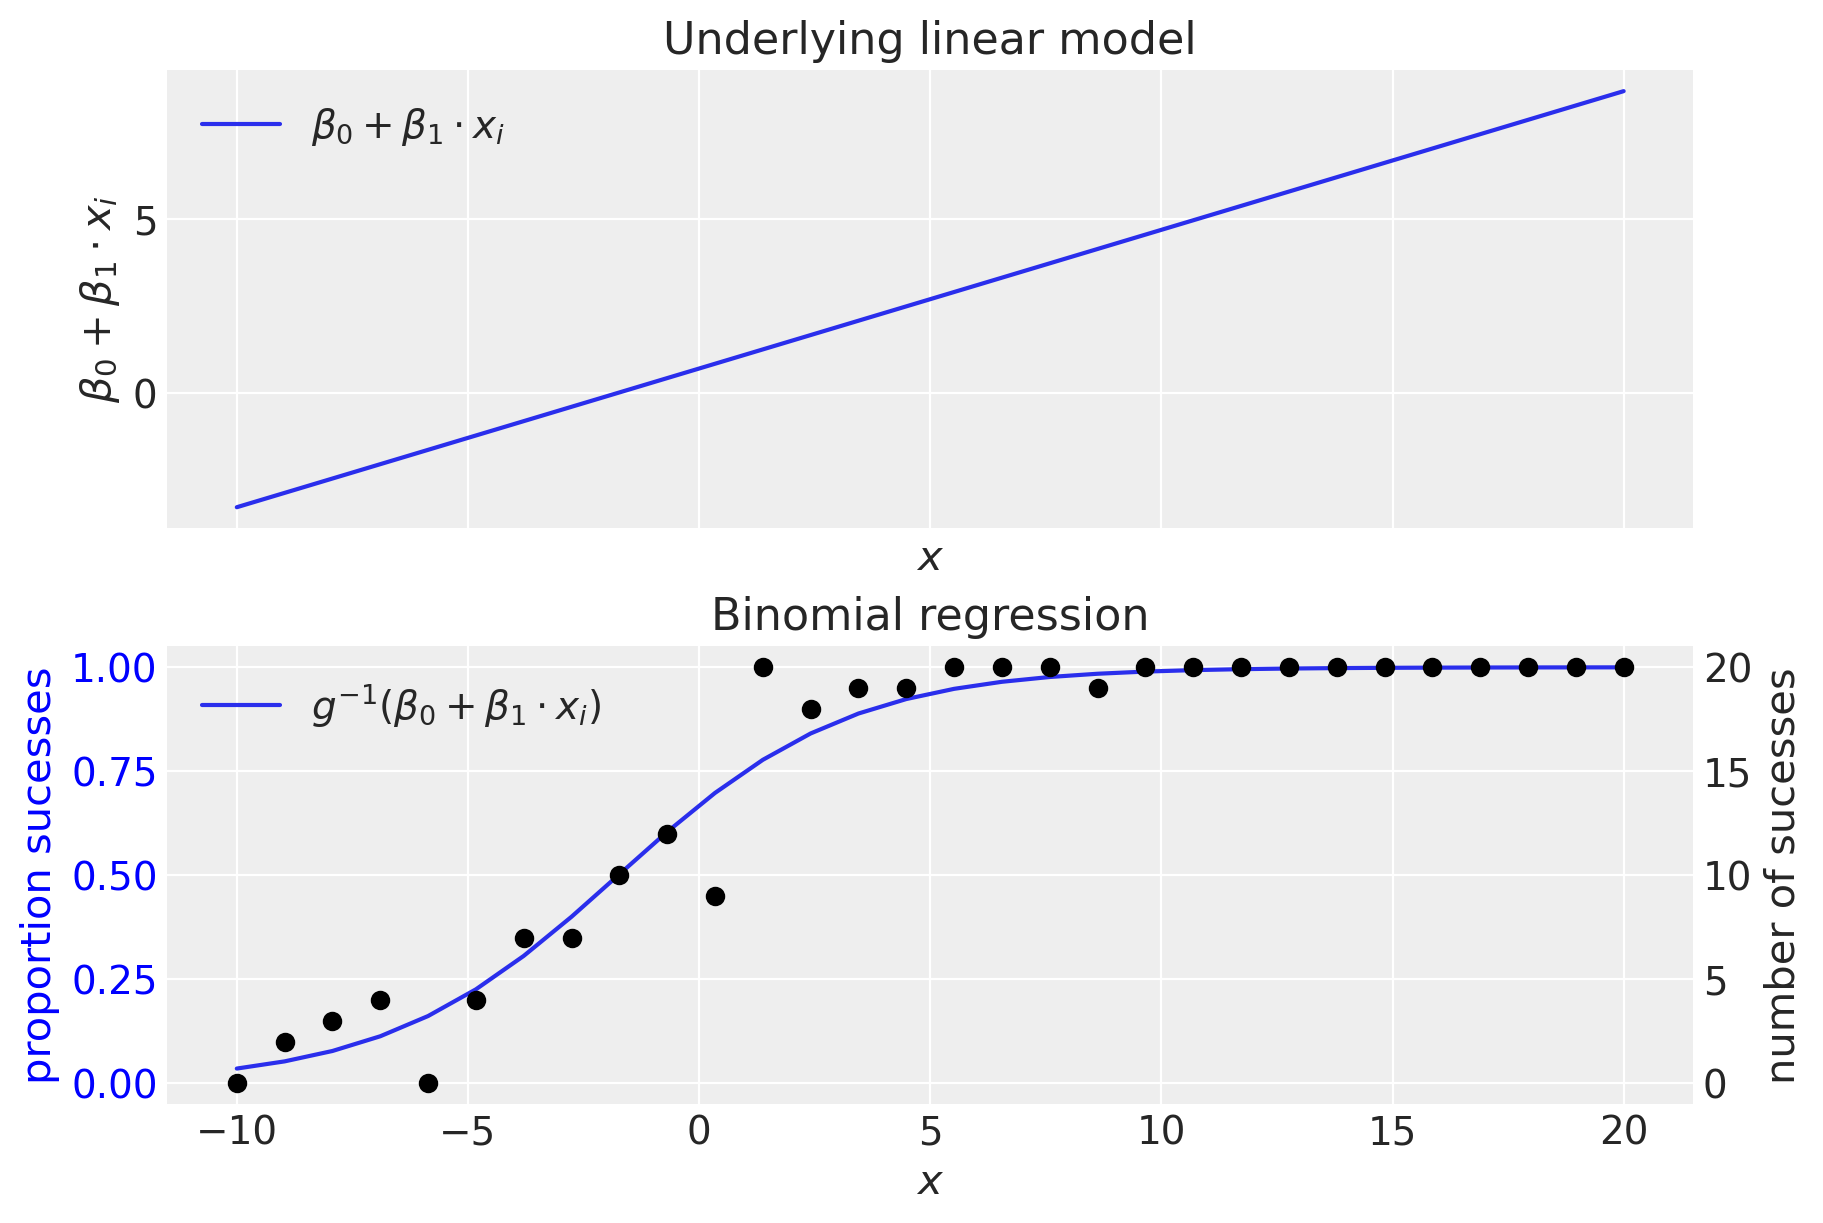

In [6]:
# Plot underlying linear model
fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax[0].plot(x, μ_true, label=r"$β_0 + β_1 \cdot x_i$")
ax[0].set(xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model")
ax[0].legend()

# Plot GLM
freq = ax[1].twinx()  # ２つ目の座標系。xはshareした上での意味でtwinx?
freq.set_ylabel("number of successes")
freq.scatter(x, y, color="k")
# plot proportion related stuff on ax[1]
ax[1].plot(x, p_true, label=r"$g^{-1}(β_0 + β_1 \cdot x_i)$")
ax[1].set_ylabel("proportion sucesses", color="b")
ax[1].tick_params(axis="y", labelcolor="b")
ax[1].set(xlabel="$x$", title="Binomial regression")
ax[1].legend()
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[1].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)

## Binoimal regressionモデル


data.index.values=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])


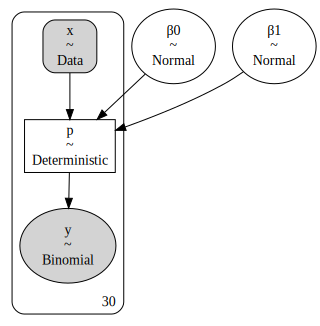

In [8]:
print(f"{data.index.values=}")
coords = {"observation": data.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.Data("x", data["x"], dims="observation")
    # priors
    β0 = pm.Normal("β0", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=1)
    # linear model
    μ = β0 + β1 * x
    p = pm.Deterministic("p", pm.math.invlogit(μ), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")

pm.model_to_graphviz(binomial_regression_model)


In [9]:
with binomial_regression_model:
    trace = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'm

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


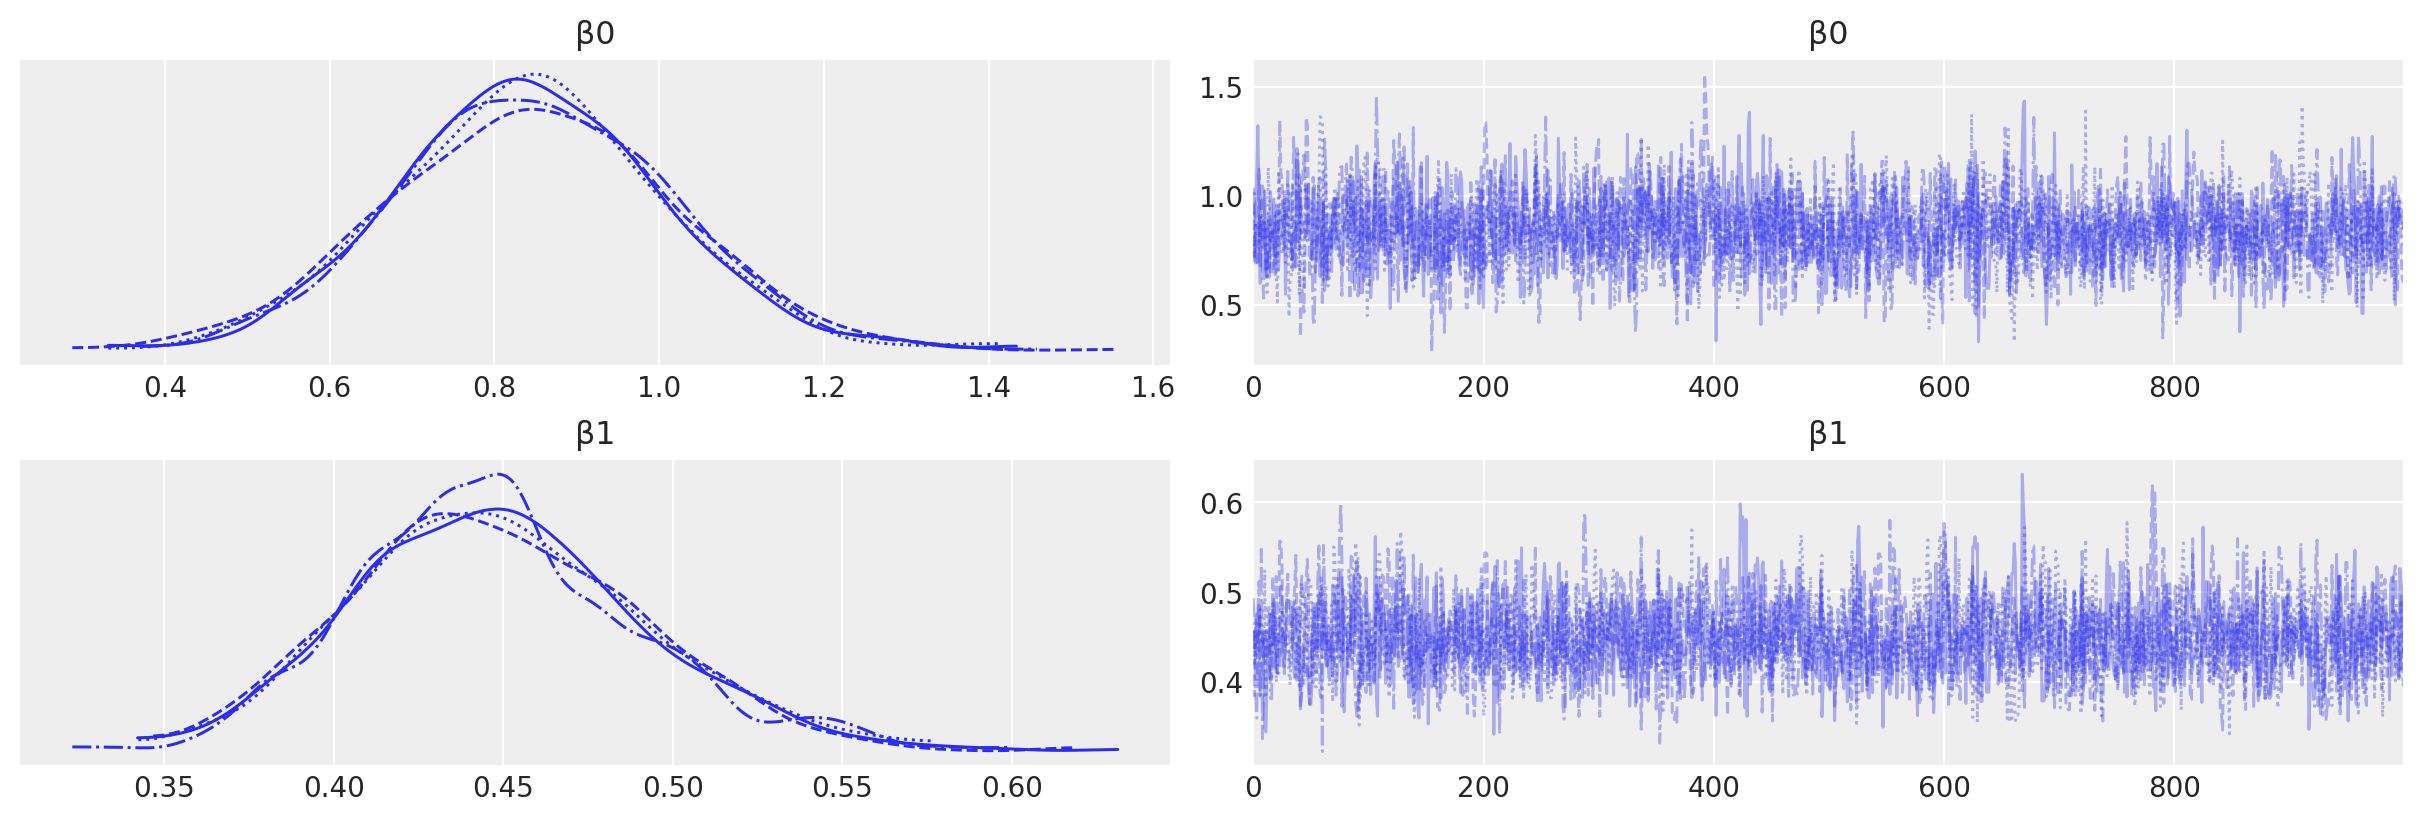

In [10]:
az.plot_trace(trace, var_names=["β0", "β1"]);

## 結果の吟味

<AxesSubplot: >

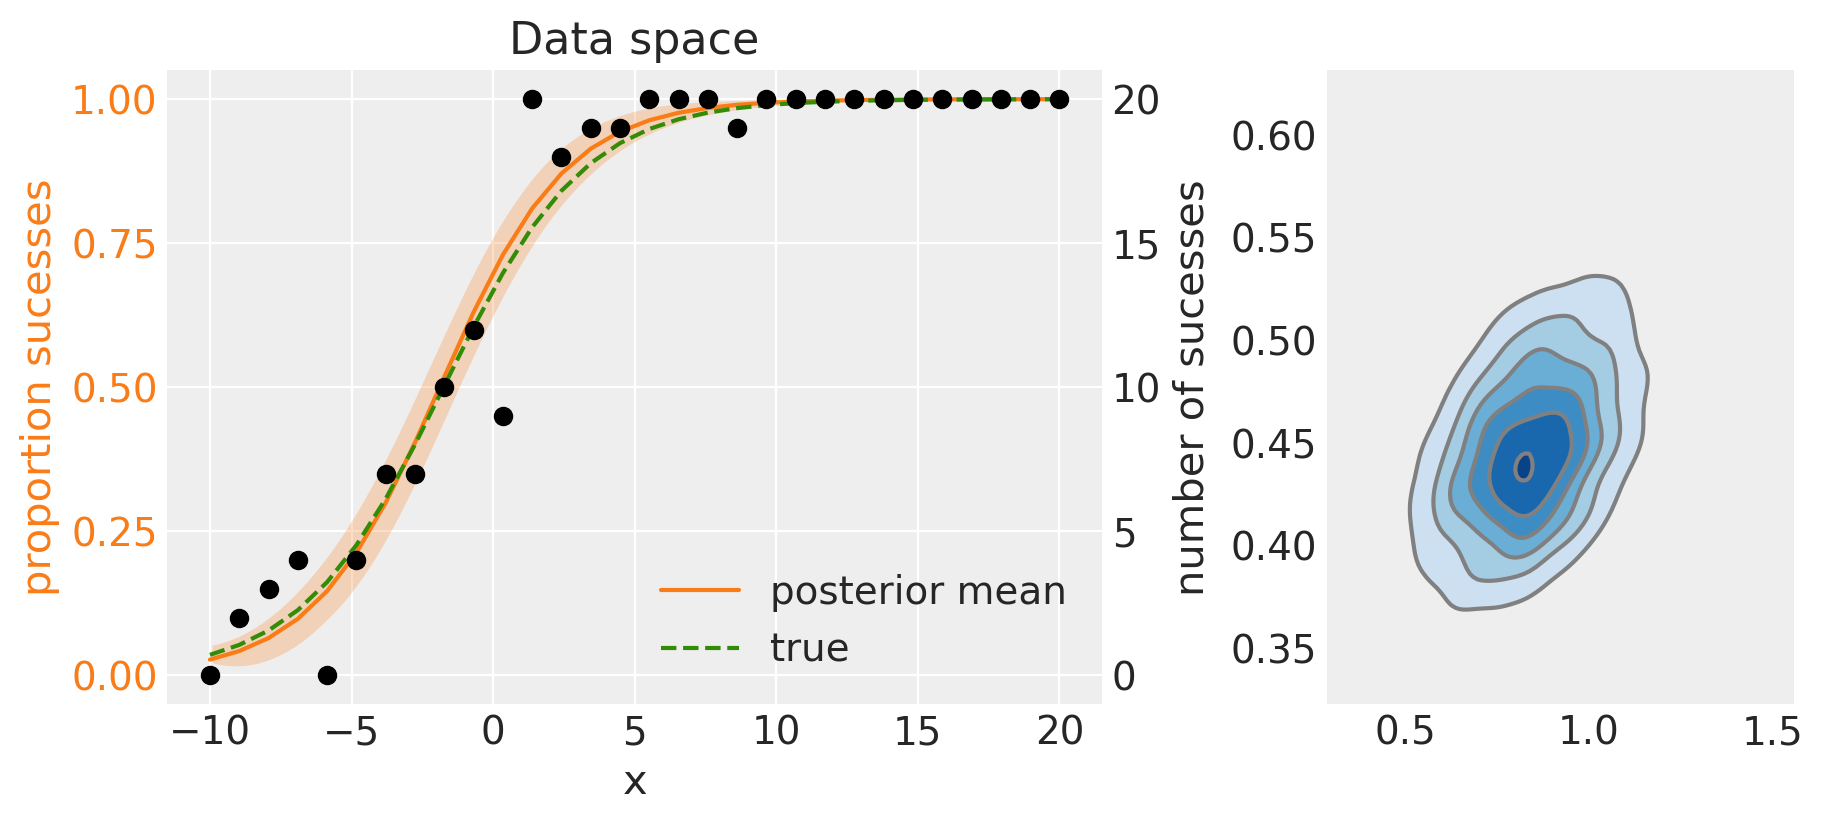

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    trace.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)

post_mean = trace.posterior.stack(sample=("chain", "draw")).p.mean("sample")
# print(f"{post_mean=}")
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion sucesses", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of sucesses")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    trace.posterior.stack(sample=("chain", "draw")).β0.values,
    trace.posterior.stack(sample=("chain", "draw")).β1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)



In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano

Last updated: Fri Dec 30 2022

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

theano: 1.1.2

numpy     : 1.22.1
pymc3     : 3.11.5
matplotlib: 3.6.2
pandas    : 1.5.2
arviz     : 0.12.1
sys       : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]

Watermark: 2.3.1

